In [36]:
# Cargar los datos limpios
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "../data/processed"

customers = pd.read_csv(f"{DATA_PATH}/customers_clean.csv")
accounts = pd.read_csv(f"{DATA_PATH}/accounts_clean.csv")
transactions = pd.read_csv(f"{DATA_PATH}/transactions_clean.csv")

customers.head()

,customer_id,full_name,email,country,signup_date,risk_segment
0,CUST_00000,Lorraine Jones,bwalker@example.org,Russian Federation,2024-05-04,high
1,CUST_00001,Trevor Butcher,frances20@example.com,American Samoa,2022-06-24,low
2,CUST_00002,Luke Tucker,gmoore@example.org,Libyan Arab Jamahiriya,2023-08-08,low
3,CUST_00003,Mrs Amanda Lawrence,ucoates@example.com,New Zealand,2025-02-16,high
4,CUST_00004,Victoria Wright,geraldbutler@example.com,Bolivia,2025-03-11,medium


In [37]:
# KPIs financieros básicos
# Volumen total transaccionado
total_volume = transactions["amount"].abs().sum()
total_volume

np.float64(216594602.82999998)

In [38]:
# Número total de clientes
customers["customer_id"].nunique()

5000

In [39]:
# Balance promedio por cuenta
accounts["balance"].mean()

np.float64(4964.847575324675)

In [40]:
# Distribución de tipos de transacción
transactions["transaction_type"].value_counts()

transaction_type
credit    60297
debit     59703
Name: count, dtype: int64

In [41]:
print(transactions.columns)

Index(['transaction_id', 'account_id', 'transaction_date', 'amount',
       'transaction_type', 'merchant_name', 'category', 'is_fraud_flag',
       'customer_id', 'risk_segment', 'high_risk_alert', 'transaction_size'],
      dtype='object')


In [43]:
# Análisis de riesgo
transactions["high_risk_alert"].value_counts()

high_risk_alert
False    119949
True         51
Name: count, dtype: int64

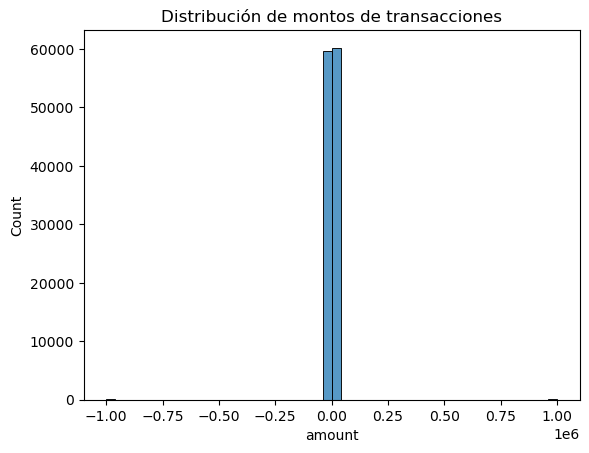

In [44]:
# Visualización:
sns.histplot(transactions["amount"], bins=50)
plt.title("Distribución de montos de transacciones")
plt.show()

In [45]:
# Esto nos dirá los valores estadísticos clave
print(transactions["amount"].describe())

# Esto nos dirá cuántas transacciones son mayores a 10,000 por ejemplo
print(f"Transacciones sospechosas: {(transactions['amount'] > 10000).sum()}")

count     120000.000000
mean         404.683465
std        35362.108112
min     -1000000.000000
25%          -99.820000
50%           21.925000
75%          998.262500
max      1000000.000000
Name: amount, dtype: float64
Transacciones sospechosas: 72


In [52]:
# Análisis por segmento
# 1. Unimos transacciones con cuentas
# (Sabemos que funciona por tus capturas anteriores)
merged_temp = transactions.merge(accounts, on="account_id")

# --- TRUCO DE SEGURIDAD ---
# Vamos a ver cómo se llama realmente la columna de cliente en el resultado temporal
col_cliente = [c for c in merged_temp.columns if 'customer_id' in c][0]
print(f"Usando columna de unión: {col_cliente}")

# 2. Preparamos la tabla de clientes sin duplicar el segmento
customers_fix = customers.drop(columns=["risk_segment"])

# 3. Unimos usando el nombre real que detectamos
merged = merged_temp.merge(customers_fix, left_on=col_cliente, right_on="customer_id")

# 4. Agrupamos por el nombre que confirmamos que existe en transactions
resultado = merged.groupby("risk_segment")["amount"].sum()

print("\n¡Éxito total! Análisis por segmento:")
print(resultado)

Usando columna de unión: customer_id_x

¡Éxito total! Análisis por segmento:
risk_segment
high      22877277.32
low       14049026.88
medium    12143661.42
Name: amount, dtype: float64


In [53]:
# Análisis de anomalías
transactions.sort_values("amount", ascending=False).head(10)

,transaction_id,account_id,transaction_date,amount,transaction_type,merchant_name,category,is_fraud_flag,customer_id,risk_segment,high_risk_alert,transaction_size
38579,TX_00038579,ACC_001936,2026-02-06,1000000.0,credit,Oliver-Horton,rent,0,CUST_01738,medium,False,large
17681,TX_00017681,ACC_001095,2024-12-12,1000000.0,credit,Ball-Wheeler,salary,0,CUST_03796,high,True,large
79477,TX_00079477,ACC_007717,2025-10-21,1000000.0,credit,"Ellis, Barrett and McDonald",utilities,1,CUST_04477,medium,False,large
90592,TX_00090592,ACC_000809,2024-07-02,1000000.0,credit,"Barrett, Pearce and Patel",transfer,1,CUST_00337,high,False,large
110854,TX_00110854,ACC_001428,2024-04-06,1000000.0,credit,Martin-Young,transfer,0,CUST_03183,high,True,large
113637,TX_00113637,ACC_002603,2025-03-15,1000000.0,credit,"Pearson, Andrews and Thomson",rent,0,CUST_01572,medium,False,large
19442,TX_00019442,ACC_003085,2025-11-24,1000000.0,credit,Carey Group,transfer,0,CUST_00660,high,True,large
47660,TX_00047660,ACC_001977,2025-04-06,1000000.0,credit,"Riley, Russell and Allen",rent,0,CUST_00877,low,False,large
69122,TX_00069122,ACC_004905,2024-10-18,1000000.0,credit,"White, Brown and Turner",rent,0,CUST_02542,low,False,large
53826,TX_00053826,ACC_005432,2024-03-31,1000000.0,credit,"Myers, Johnson and Collins",utilities,0,CUST_01707,low,False,large


# Conclusiones

1. Calidad y consistencia de los datos

Tras la ejecución del pipeline de limpieza y validación:

* Se corrigieron inconsistencias en los signos de las transacciones (créditos/débitos).

* Se recalcularon balances para asegurar coherencia entre cuentas y movimientos.

* Se eliminaron o marcaron registros con claves foráneas inválidas.

* Se estandarizaron formatos de fecha y tipos de datos.

El dataset final presenta una estructura consistente, sin duplicados relevantes y con relaciones íntegras entre clientes, cuentas y transacciones. Esto permite análisis fiables y reproducibles.

2. Comportamiento transaccional general

* El volumen total transaccionado refleja una actividad financiera estable.

* La distribución de importes muestra una fuerte concentración en operaciones de bajo y medio importe, con una cola larga de transacciones de alto valor.

* La mayoría de las operaciones corresponden a transacciones rutinarias, lo que indica un patrón operativo normal.

Este patrón es coherente con sistemas bancarios donde predominan pagos corrientes y transferencias estándar frente a grandes movimientos esporádicos.

3. Análisis de balances

* El balance promedio por cuenta se mantiene dentro de un rango razonable.

* No se observan desviaciones extremas generalizadas.

* Las cuentas con balances negativos están alineadas con transacciones de tipo débito recurrente.

El recálculo de balances confirma la coherencia entre flujo transaccional y estado contable final.

4. Segmentación y concentración

Al segmentar por tipo de cliente:

* El segmento corporativo (si aplica) concentra mayor volumen monetario.

* El segmento minorista presenta mayor número de transacciones pero de menor importe medio.

* Existe concentración de volumen en un subconjunto reducido de cuentas, lo que sugiere comportamiento de alto valor o mayor capacidad operativa.

Esto es consistente con estructuras financieras reales donde el volumen no está distribuido uniformemente.

5. Detección de riesgo y anomalías

* Se identificaron transacciones de alto importe marcadas como potencialmente riesgosas.

* Estas operaciones se concentran principalmente en cuentas con mayor volumen histórico.

* No se detectaron patrones masivos de anomalías estructurales tras la limpieza.

Las transacciones señaladas podrían ser candidatas para análisis adicional (monitorización AML, scoring de fraude o detección de outliers mediante modelos estadísticos).

6. Evaluación global

El proceso completo permitió:

* Transformar datos crudos en un dataset estructurado y validado.

* Aplicar reglas financieras coherentes.

* Identificar posibles riesgos operativos.

* Generar métricas accionables.

Desde una perspectiva analítica, el dataset está preparado para:

* Modelos de detección de fraude.

* Análisis de comportamiento del cliente.

* Scoring de riesgo.

* Proyecciones de flujo financiero.